## Classifying Traffic Images

In this notebook, I classify traffic images as 'accident', 'dense_traffic', 'fire', or 'sparse_traffic.' 

The data can be found here: https://github.com/OlafenwaMoses/Traffic-Net. It consists of 4400 .jpg images of traffic, evenly distributed among the four classes. 

I use a number of techniques to classify the images, including a simple dense network, a convolutional neural network, and transfer learning. I also experiment with data augmentation and dropout. 

Using accuracy to evaluate my models, I achieve the following results: 

| Model                                  | Accuracy | 
| :----                                  |    ----:   |
| Baseline (random)                      | .25       | 
| Dense Net                              | .4        |
| CNN                                    | .67        |
| CNN with dropout & data augmentation   | .78        |

To code this notebook, I relied heavily on the instruction provided in the book *Deep Learning with Python, Second Edition* by François Chollet.


In [1]:
import numpy as np 
import pandas as pd 
import os, shutil

In [2]:
cd ..

/kaggle


In [3]:
cd /kaggle/input/trafficimages/

/kaggle/input/trafficimages


In [4]:
new_base_dir = 'trafficnet_dataset_v1/'

In [5]:
# creating directories

train_dir = os.path.join(new_base_dir, 'train')
test_dir = os.path.join(new_base_dir, 'test')

train_accident_dir = os.path.join(train_dir, 'accident')
train_dense_dir = os.path.join(train_dir, 'dense_traffic')
train_fire_dir = os.path.join(train_dir, 'fire')
train_sparse_dir = os.path.join(train_dir, 'sparse_traffic')

test_accident_dir = os.path.join(test_dir, 'accident')
test_dense_dir = os.path.join(test_dir, 'dense_traffic')
test_fire_dir = os.path.join(test_dir, 'fire')
test_sparse_dir = os.path.join(test_dir, 'sparse_traffic')

all_dir = [train_accident_dir, train_dense_dir, train_fire_dir, train_sparse_dir, test_accident_dir, 
           test_dense_dir, test_fire_dir, test_sparse_dir]

In [6]:
# checking the total number of training and testing images for each class 

print('total training accident images:', len(os.listdir(train_accident_dir)))
print('total training dense images:', len(os.listdir(train_dense_dir)))
print('total training fire images:', len(os.listdir(train_fire_dir)))
print('total training sparse images:', len(os.listdir(train_sparse_dir)))
print('total testing accident images:', len(os.listdir(test_accident_dir)))
print('total testing dense images:', len(os.listdir(test_dense_dir)))
print('total testing fire images:', len(os.listdir(test_fire_dir)))
print('total testing sparse images:', len(os.listdir(test_sparse_dir)))

total training accident images: 900
total training dense images: 900
total training fire images: 900
total training sparse images: 901
total testing accident images: 200
total testing dense images: 200
total testing fire images: 200
total testing sparse images: 200


In [7]:
# creating image datasets from the directory

from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset = "training",
    seed=123,
    image_size=(180, 180),
    batch_size=32)

val_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset = "validation",
    seed=123,
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(180, 180),
    batch_size=32)

Found 3600 files belonging to 4 classes.
Using 2880 files for training.


2022-05-25 20:51:45.877143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 20:51:46.025259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 20:51:46.025988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 20:51:46.029984: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 3600 files belonging to 4 classes.
Using 720 files for validation.
Found 800 files belonging to 4 classes.


In [8]:
# checking out the batch and labels shape

for data_batch, labels_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

2022-05-25 20:51:49.050020: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


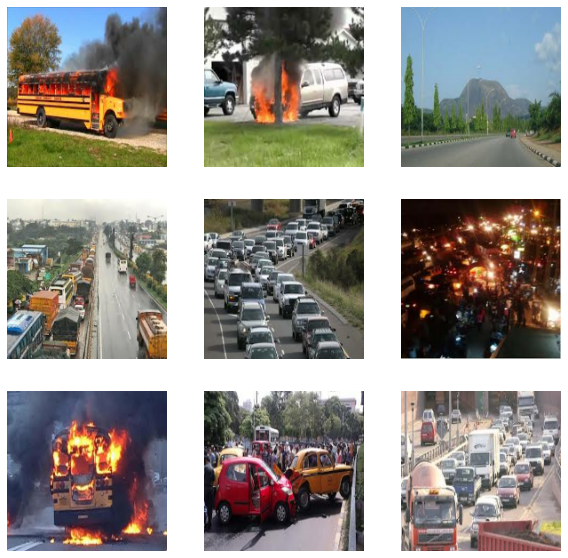

In [9]:
# looking at some images 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [10]:
# checking the class names

class_names = train_dataset.class_names
print(class_names)

['accident', 'dense_traffic', 'fire', 'sparse_traffic']


In [11]:
# creating datasets from directories 
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset = "training",
    seed=123,
    image_size=(180, 180),
    batch_size=32)

val_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset = "validation",
    seed=123,
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(180, 180),
    batch_size=32)

Found 3600 files belonging to 4 classes.
Using 2880 files for training.
Found 3600 files belonging to 4 classes.
Using 720 files for validation.
Found 800 files belonging to 4 classes.


## Training a Dense Network

In [12]:
# defining and compiling a densely connected model

from tensorflow import keras 
from tensorflow.keras import layers
from matplotlib.cbook import flatten

  
model = keras.Sequential([
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(4, activation="softmax")
])

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# train the model

history = model.fit(train_dataset, epochs=18, validation_data=val_dataset)

Epoch 1/18
90/90 [==============================] - 9s 88ms/step - loss: 14932.2148 - accuracy: 0.2951 - val_loss: 5625.3804 - val_accuracy: 0.4264
Epoch 2/18
90/90 [==============================] - 4s 40ms/step - loss: 6770.6006 - accuracy: 0.3438 - val_loss: 3695.1646 - val_accuracy: 0.3819
Epoch 3/18
90/90 [==============================] - 4s 39ms/step - loss: 5474.6162 - accuracy: 0.3760 - val_loss: 4233.8481 - val_accuracy: 0.3861
Epoch 4/18
90/90 [==============================] - 4s 39ms/step - loss: 4627.7300 - accuracy: 0.3781 - val_loss: 6527.2896 - val_accuracy: 0.2889
Epoch 5/18
90/90 [==============================] - 4s 42ms/step - loss: 4222.8438 - accuracy: 0.4049 - val_loss: 4558.1050 - val_accuracy: 0.3528
Epoch 6/18
90/90 [==============================] - 4s 38ms/step - loss: 3483.1143 - accuracy: 0.4073 - val_loss: 1097.7760 - val_accuracy: 0.4708
Epoch 7/18
90/90 [==============================] - 4s 39ms/step - loss: 3149.1201 - accuracy: 0.4000 - val_loss: 200

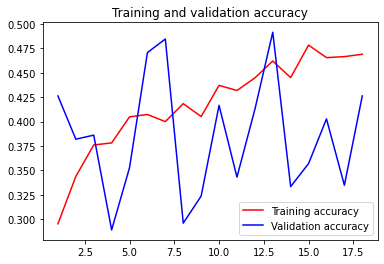

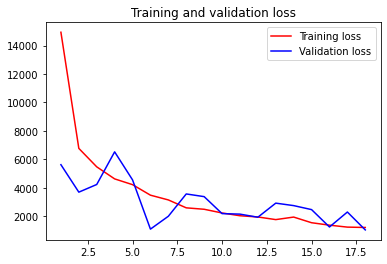

In [14]:
# plotting validation and training losses and accuracy

import matplotlib.pyplot as plt

def plotAccuracy(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "r", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()

def plotLoss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, "r", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

    
plotAccuracy(history)    
plotLoss(history)

In [15]:
# evaluating the model on the test set 

test_loss, test_acc = model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

25/25 [==============================] - 2s 41ms/step - loss: 1078.9773 - accuracy: 0.4175
Test accuracy: 0.417


## Training a Convolutional Neural Network

In [16]:
# building CNN model

from tensorflow import keras 
from tensorflow.keras import layers
  
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
#x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(124)(x)
outputs = layers.Dense(4)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [17]:
# checking out the model

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

In [18]:
# compiling model

import tensorflow as tf
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
# training the model

import keras

history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=val_dataset)

Epoch 1/15


2022-05-25 20:53:17.708942: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


90/90 [==============================] - 10s 44ms/step - loss: 1.3117 - accuracy: 0.5233 - val_loss: 0.9610 - val_accuracy: 0.5708
Epoch 2/15
90/90 [==============================] - 4s 41ms/step - loss: 0.8288 - accuracy: 0.6628 - val_loss: 0.7868 - val_accuracy: 0.6847
Epoch 3/15
90/90 [==============================] - 5s 48ms/step - loss: 0.7198 - accuracy: 0.7181 - val_loss: 0.7044 - val_accuracy: 0.7458
Epoch 4/15
90/90 [==============================] - 4s 40ms/step - loss: 0.6230 - accuracy: 0.7646 - val_loss: 0.7348 - val_accuracy: 0.7056
Epoch 5/15
90/90 [==============================] - 4s 42ms/step - loss: 0.5612 - accuracy: 0.7934 - val_loss: 0.6832 - val_accuracy: 0.7375
Epoch 6/15
90/90 [==============================] - 4s 41ms/step - loss: 0.5019 - accuracy: 0.8170 - val_loss: 0.7222 - val_accuracy: 0.7208
Epoch 7/15
90/90 [==============================] - 4s 41ms/step - loss: 0.3659 - accuracy: 0.8667 - val_loss: 0.7531 - val_accuracy: 0.7375
Epoch 8/15
90/90 [=====

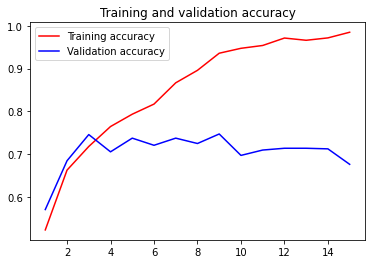

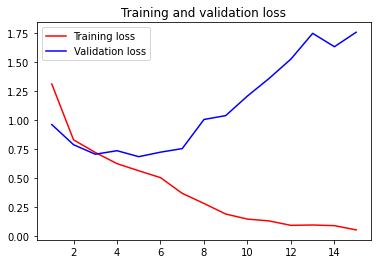

In [20]:
# plotting validation and training losses and accuracy

plotAccuracy(history)    
plotLoss(history)

In [21]:
# evaluating the model

test_loss, test_acc = model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

25/25 [==============================] - 1s 24ms/step - loss: 1.8567 - accuracy: 0.6812
Test accuracy: 0.681


## Adding Data Augmentation and Dropout

In [22]:
# defining data augmentation layer

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
    ]
)

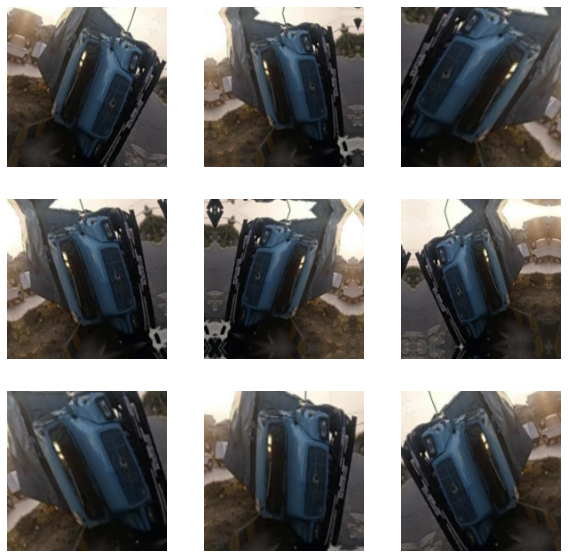

In [23]:
# looking at the augmented data

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [24]:
# building model with augmented data

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
# training the model

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset)

Epoch 1/10
90/90 [==============================] - 6s 52ms/step - loss: 1.1377 - accuracy: 0.4535 - val_loss: 0.9735 - val_accuracy: 0.5792
Epoch 2/10
90/90 [==============================] - 4s 41ms/step - loss: 0.9272 - accuracy: 0.6021 - val_loss: 0.8882 - val_accuracy: 0.6375
Epoch 3/10
90/90 [==============================] - 4s 44ms/step - loss: 0.8184 - accuracy: 0.6597 - val_loss: 0.7818 - val_accuracy: 0.6694
Epoch 4/10
90/90 [==============================] - 4s 41ms/step - loss: 0.7641 - accuracy: 0.6993 - val_loss: 0.7262 - val_accuracy: 0.7069
Epoch 5/10
90/90 [==============================] - 4s 41ms/step - loss: 0.6822 - accuracy: 0.7375 - val_loss: 0.6614 - val_accuracy: 0.7458
Epoch 6/10
90/90 [==============================] - 4s 41ms/step - loss: 0.5811 - accuracy: 0.7781 - val_loss: 0.6624 - val_accuracy: 0.7333
Epoch 7/10
90/90 [==============================] - 4s 41ms/step - loss: 0.5382 - accuracy: 0.7976 - val_loss: 0.6030 - val_accuracy: 0.7722
Epoch 8/10
90

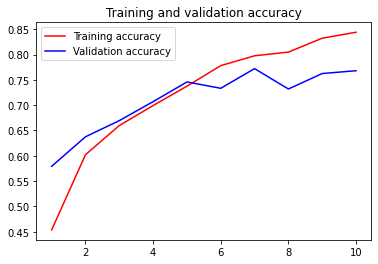

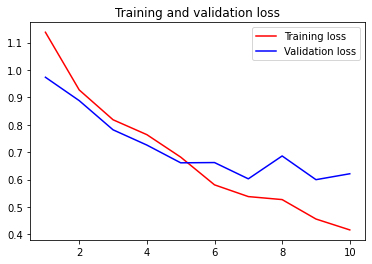

In [26]:
# looking at validation and training acciracy and losses

plotAccuracy(history)    
plotLoss(history)

In [27]:
# evaluating on the test set

test_loss, test_acc = model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

25/25 [==============================] - 1s 23ms/step - loss: 0.6755 - accuracy: 0.7475
Test accuracy: 0.748
